In [1]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.models import Sequential

2022-05-01 17:10:02.069471: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 17:10:02.069523: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_data = pd.read_csv("train.csv").fillna(0)
train_data =train_data.sample(frac=1)

In [3]:
test_data = pd.read_csv("test.csv").fillna(0)
test_data =test_data.sample(frac=1)

In [4]:
merged_data = pd.concat(
    (train_data, test_data),
    axis=0,
    join="outer")
merged_data.head()

,5 Minutes,Lane 1 Flow (Veh/5 Minutes),# Lane Points,% Observed
4944,09/02/2016 4:00,14,1,100
12,04/01/2016 1:00,8,1,100
5989,18/02/2016 19:05,79,1,100
3709,01/02/2016 21:05,42,1,100
3730,01/02/2016 22:50,16,1,100


In [5]:
train_data = merged_data.sample(frac=0.8,random_state=20)
test_data = merged_data.drop(train_data.index)

In [6]:
attribute = 'Lane 1 Flow (Veh/5 Minutes)'
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_data[attribute].values.reshape(-1, 1))
train_transform = scaler.transform(train_data[attribute].values.reshape(-1, 1)).reshape(1, -1)[0]
test_transform = scaler.transform(test_data[attribute].values.reshape(-1, 1)).reshape(1, -1)[0]
train, test = [], []
delay = 256
for i in range(delay, len(train_transform)):
    train.append(train_transform[i - delay: i + 1])
for i in range(delay, len(test_transform)):
    test.append(test_transform[i - delay: i + 1])
train = np.array(train)
test = np.array(test)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = test[:, :-1]
y_test = test[:, -1]

In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], -1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], -1))

In [8]:
X_train = tf.transpose(X_train, [0, 2, 1])
X_test = tf.transpose(X_test, [0, 2, 1])

In [9]:
model = models.Sequential()
model.add(layers.Conv1D(256, 1, activation='softmax', input_shape=(1, 256)))
model.add(tf.keras.layers.LeakyReLU())
model.add(layers.Conv1D(64, 1, activation='softmax',  input_shape=(256, 64)))
model.add(layers.Conv1D(64, 1, activation='softmax',  input_shape=(128, 16)))
model.add(layers.Conv1D(64, 1, activation='softmax',  input_shape=(64, 8)))
model.add(layers.MaxPooling1D(1))
model.add(layers.Conv1D(64, 1, activation='relu'))
model.add(layers.Activation("relu"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 256)            65792     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 256)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                        

In [10]:
model.compile(loss="mse", optimizer="Adam")

In [11]:
history = model.fit(X_train, y_train, batch_size = 1, epochs=10, shuffle=True,verbose=1, validation_split = 0.2)

Epoch 1/10
7536/7536 [==============================] - 11s 1ms/step - loss: 0.1032 - val_loss: 0.1001
Epoch 2/10
7536/7536 [==============================] - 11s 1ms/step - loss: 0.1010 - val_loss: 0.0976
Epoch 3/10
7536/7536 [==============================] - 11s 1ms/step - loss: 0.1000 - val_loss: 0.0926
Epoch 4/10
7536/7536 [==============================] - 11s 1ms/step - loss: 0.0952 - val_loss: 0.0923
Epoch 5/10
7536/7536 [==============================] - 11s 1ms/step - loss: 0.0952 - val_loss: 0.0923
Epoch 6/10
7536/7536 [==============================] - 11s 1ms/step - loss: 0.0952 - val_loss: 0.0924
Epoch 7/10
7536/7536 [==============================] - 11s 1ms/step - loss: 0.0952 - val_loss: 0.0925
Epoch 8/10
7536/7536 [==============================] - 11s 1ms/step - loss: 0.0952 - val_loss: 0.0925
Epoch 9/10
7536/7536 [==============================] - 11s 1ms/step - loss: 0.0952 - val_loss: 0.0924
Epoch 10/10
7536/7536 [==============================] - 11s 1ms/step - l

In [12]:
import pickle
pickle.dump(model, open('model', 'wb'))

2022-05-01 17:11:52.014868: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://2ae0c5e6-5a56-4ba9-9d12-3d8c48f4c227/assets


In [13]:
loaded_model = pickle.load(open('model', 'rb'))

In [14]:
y_pred = loaded_model.predict(X_test)

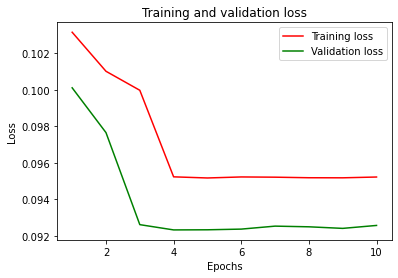

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()